In [59]:
# 甘藍價格預測版本v2，此版本目的是可以跑完模型並畫出圖，尚無判斷參數的選擇，以及預測結果是否合理

In [60]:
import pandas as pd
import urllib.request
import os
import datetime
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
# 是否要加入天氣資料
add_weathen_data = True
# 是否要加入颱風資料
add_typhoon_data = False
# 設定往前以及往後看的天數, pastDay, futureDay要設定一樣的值
pastDay = 10
futureDay = 10
# 畫多少天的預測圖，要小於或等於上面的數字
plotDay = 10
# 訂定訓練資料的期間、測試資料的期間
train_start_date = '2017-01-01'
train_end_date = '2020-12-31'
test_start_date = '2021-01-01'
test_end_date = '2021-06-30'
# 使用哪一個模型，目前有1, 2
model_no = 1

In [62]:
# 檔案下載url
weather_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/reportdaily_mean_fillna.csv'
typhoon_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/TyphoonDatabase.csv'
cabbage_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/Cabbage.csv'

In [63]:
# 將檔案下載至colab
if not os.path.exists('weather.csv'): urllib.request.urlretrieve(weather_data_url, 'weather.csv') 
if not os.path.exists('typhoon.csv'): urllib.request.urlretrieve(typhoon_data_url, 'typhoon.csv') 
if not os.path.exists('cabbage.csv'): urllib.request.urlretrieve(cabbage_data_url, 'cabbage.csv') 

In [64]:
# 所有城市對照英文代碼
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}

In [65]:
# 要移除的欄位列表
# weather columb全部列表: 'date', 'city', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 'StnPresMin', 'StnPresMinTime', 'Temperature', 'TMax', 'TMaxTime', 'TMin', 'TMinTime', 'TdDewPoint', 'RH', 'RHMin', 'RHMinTime', 'WS', 'WD', 'WSGust', 'WDGust', 'WGustTime', 'Precp', 'PrecpHour', 'PrecpMax10', 'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVIMax', 'UVIMaxTime', 'CloudAmount'
weather_drop_columns = [
                        'StnPresMaxTime', 
                        'StnPresMinTime', 
                        'TMaxTime', 
                        'TMinTime', 
                        'RHMinTime', 
                        'WGustTime', 
                        'PrecpMax10', 
                        'PrecpMax10Time', 
                        'PrecpMax60', 
                        'PrecpMax60Time', 
                        'UVIMax', 
                        'UVIMaxTime'
]

In [66]:
# 移除不需要的欄位
df = pd.read_csv('weather.csv', encoding='utf-8')
df = df.drop(weather_drop_columns, axis=1)
df.head(3)

,date,city,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,TMax,TMin,TdDewPoint,RH,RHMin,WS,WD,WSGust,WDGust,Precp,PrecpHour,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,CloudAmount
0,2000-01-01,南投縣,773.0,1527.9,775.0,771.4,9.0,14.3,6.5,1.1,60.0,37.5,7.5,301.0,14.1,262.5,0.0,0.0,9.8,91.5,12.0,34.4,2.8,1.4
1,2000-01-01,嘉義市,1013.0,1016.3,1015.5,1010.1,18.9,26.0,13.4,14.3,77.0,41.0,2.0,20.0,8.4,30.0,0.0,0.0,7.6,71.2,9.4,4.6,2.8,1.8
2,2000-01-01,嘉義縣,874.2,3156.4,767.6,764.6,14.0,14.9,3.7,-3.6,44.0,18.0,1.8,300.0,6.3,90.0,0.0,0.0,9.2,96.5,18.4,44.2,2.1,0.5


In [67]:
# 使用index做merge，將weather表格依日期拉平
df_date = df['date'].drop_duplicates().to_frame().set_index('date')

for cityname, citycode in city.items():
    df_city = df.loc[df['city'] == cityname].add_suffix('_' + citycode).set_index('date' + '_' + citycode)
    df_date = pd.merge(df_date, df_city, how='left', left_index = True, right_index = True)

df_date = df_date[df_date.columns.drop(list(df_date.filter(regex='city')))]
df_weather = df_date

df_weather.head(3)

,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMin_KLU,Temperature_KLU,TMax_KLU,TMin_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,Precp_KLU,PrecpHour_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,CloudAmount_KLU,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMin_TPE,Temperature_TPE,TMax_TPE,TMin_TPE,TdDewPoint_TPE,RH_TPE,RHMin_TPE,WS_TPE,WD_TPE,WSGust_TPE,WDGust_TPE,Precp_TPE,PrecpHour_TPE,SunShine_TPE,SunShineRate_TPE,...,Temperature_HWA,TMax_HWA,TMin_HWA,TdDewPoint_HWA,RH_HWA,RHMin_HWA,WS_HWA,WD_HWA,WSGust_HWA,WDGust_HWA,Precp_HWA,PrecpHour_HWA,SunShine_HWA,SunShineRate_HWA,GloblRad_HWA,VisbMean_HWA,EvapA_HWA,CloudAmount_HWA,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMin_TTT,Temperature_TTT,TMax_TTT,TMin_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,Precp_TTT,PrecpHour_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,CloudAmount_TTT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1009.2,1016.9,1011.0,1007.2,19.3,22.6,16.9,14.3,73.5,63.0,3.8,280.0,10.6,180.0,2.2,0.4,3.8,36.6,5.6,13.9,2.0,6.0,996.4,1184.6,998.6,994.4,17.5,21.1,14.3,11.9,78.7,51.0,1.2,230.9,7.2,197.3,0.0,0.0,2.7,25.9,...,18.5,24.9,13.5,16.4,74.0,58.0,0.8,221.7,4.5,162.7,0.5,0.0,4.1,37.0,7.9,12.8,1.2,7.4,956.6,1015.0,989.5,982.9,19.2,25.0,17.7,16.9,74.8,61.8,1.8,119.2,7.2,75.2,0.0,0.0,3.1,28.9,7.6,15.5,2.9,7.1
2000-01-02,1010.9,1018.6,1012.6,1008.8,18.6,21.7,15.2,11.4,64.5,54.5,4.7,130.0,11.7,85.0,0.0,0.0,8.5,79.8,8.0,9.3,2.6,3.8,997.6,1187.6,999.4,995.2,16.8,22.6,12.1,9.0,68.7,43.3,1.9,98.3,10.0,93.7,0.0,0.0,7.6,71.9,...,17.9,23.0,14.6,13.7,62.0,42.0,1.1,215.7,6.7,139.9,0.3,0.0,2.6,23.0,7.2,13.0,1.5,9.0,957.0,1015.9,976.0,971.3,17.9,22.1,16.5,14.1,64.0,50.2,2.8,119.8,11.4,89.7,0.0,0.0,4.2,38.9,8.5,14.6,3.6,6.9
2000-01-03,1011.0,1018.6,1012.9,1009.2,18.7,20.8,16.3,10.0,58.0,48.0,3.9,60.0,10.3,85.0,0.0,0.0,5.0,47.4,7.0,8.8,3.0,5.1,997.1,1185.5,999.0,995.4,17.6,20.8,15.3,10.7,76.7,62.3,2.3,79.2,10.3,89.0,0.0,0.0,4.6,43.2,...,16.7,22.1,12.9,13.5,67.0,56.0,0.8,210.9,4.8,172.4,0.1,0.0,1.8,16.7,5.0,10.3,2.5,8.5,958.2,1016.9,989.8,986.6,16.9,22.2,16.2,13.5,64.2,56.5,2.2,101.1,9.8,66.7,0.0,0.0,5.2,47.8,8.0,13.1,3.2,6.5


In [68]:
# 計算兩個日期間隔多少天
def daysBetweenDate(startdate: str, enddate: str) -> int:
    startdate = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    enddate = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    days = (enddate - startdate).days + 1
    return days

# 日期調整
def dateShift(startdate: str, shiftday: int) -> str:
    startdate = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    targetdate = startdate + datetime.timedelta(days=shiftday)
    return datetime.datetime.strftime(targetdate, "%Y-%m-%d")

# 讀取颱風資料庫
df_typhoon = pd.read_csv('typhoon.csv', encoding='utf-8')

# 將Warning的日期文字轉為4個欄位'startdate','starttime','enddate','endtime'
df_typhoon[['startdate','starttime','enddate','endtime']] = df_typhoon['Warning'].str.split().tolist()
# 將最前面塞入date欄位
df_typhoon_new = pd.DataFrame(columns=df_typhoon.columns.insert(0, 'date'))

# 將所有颱風按日期列出
# 使用iterrows
start_time = time.time()
for index, row in df_typhoon.iterrows():
    days = daysBetweenDate(row['startdate'], row['enddate'])
    for day in range(0, days):
        date = dateShift(row['startdate'],day)
        datesr1 = pd.Series(date).append(df_typhoon.iloc[index]).rename({0: 'date'})
        df_typhoon_new = df_typhoon_new.append(datesr1, ignore_index=True)

# 將相同日期的去除並暫時只留WarnMark欄位
df_typhoon_wm = pd.DataFrame(df_typhoon_new, columns=['date'])
df_typhoon_wm['WarnMark'] = 1
df_typhoon_wm = df_typhoon_wm.drop_duplicates().reset_index().drop(columns=['index'])

df_typhoon = df_typhoon_wm.set_index('date')

print(df_typhoon.head(3))


            WarnMark
date                
2021-06-03         1
2021-06-04         1
2020-11-05         1


In [69]:
# 讀取甘藍菜資料
df = pd.read_csv('cabbage.csv', encoding='utf-8')
# 將休市價格填入前一日價格
df = df.fillna(method="ffill")
# 只拿出台北一的資料
df = df[df.Market == '台北一']

df = df.dropna()
df_cabbage = df.rename(columns={'Date': 'date'}).set_index('date')

print(df_cabbage.head(3))
print(df_cabbage.tail(3))

           Market     Product  Up_price  ...  Week_day  Year  Rest_day
date                                     ...                          
2000-01-02    台北一  LA1 甘藍 初秋       11.0  ...         7  2000         0
2000-01-03    台北一  LA1 甘藍 初秋        9.0  ...         1  2000         0
2000-01-04    台北一  LA1 甘藍 初秋        8.0  ...         2  2000         0

[3 rows x 11 columns]
           Market     Product  Up_price  ...  Week_day  Year  Rest_day
date                                     ...                          
2021-06-17    台北一  LA1 甘藍 初秋       21.8  ...         4  2021         0
2021-06-18    台北一  LA1 甘藍 初秋       21.9  ...         5  2021         0
2021-06-19    台北一  LA1 甘藍 初秋       21.1  ...         6  2021         0

[3 rows x 11 columns]


In [70]:
df_all = df_cabbage
# 是否要合併資料
if add_weathen_data is True:
  df_all = pd.merge(df_all, df_weather, how='inner', left_index = True, right_index = True)
if add_typhoon_data is True:
  df_all = pd.merge(df_all, df_typhoon, how='left', left_index = True, right_index = True).fillna(0)

# 把平均價格移到最後1欄
col_Avg_price = df_all.pop('Avg_price')
df_all = pd.concat([df_all, col_Avg_price], 1)
print(df_all.head(3))
print(df_all.tail(3))

           Market     Product  Up_price  ...  EvapA_TTT  CloudAmount_TTT  Avg_price
date                                     ...                                       
2000-01-02    台北一  LA1 甘藍 初秋       11.0  ...        3.6              6.9        8.9
2000-01-03    台北一  LA1 甘藍 初秋        9.0  ...        3.2              6.5        7.2
2000-01-04    台北一  LA1 甘藍 初秋        8.0  ...        2.6              7.0        6.7

[3 rows x 429 columns]
           Market     Product  Up_price  ...  EvapA_TTT  CloudAmount_TTT  Avg_price
date                                     ...                                       
2021-06-16    台北一  LA1 甘藍 初秋       27.4  ...        7.4              4.4       21.0
2021-06-17    台北一  LA1 甘藍 初秋       21.8  ...        7.2              2.5       15.1
2021-06-18    台北一  LA1 甘藍 初秋       21.9  ...        6.9              2.4       15.1

[3 rows x 429 columns]


In [71]:
# 將資料整理為x_train, y_train
def buildTrain(train, pastDay=30, futureDay=5):
  x_train, y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    x_train.append(train[i:i+pastDay])
    y_train.append(train[i+pastDay:i+pastDay+futureDay, -1])
  return np.array(x_train), np.array(y_train)

In [72]:
# 將資料切分為訓練資料及驗證資料
def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [73]:
# 將資料複製一份來作業, 將欄位index改為date
df = df_all.copy()
df = df.reset_index().rename(columns={'index': 'date'})

# 依訓練資料的期間、測試資料的期間來切分資料
df_train = df.iloc[df[(train_start_date <= df.date) & (df.date <= train_end_date)].index].set_index('date')
df_test = df.iloc[df[(test_start_date <= df.date) & (df.date <= test_end_date)].index].set_index('date')

# 將非數字的欄位移除
df_train = df_train.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])

print(df_train.dtypes)

Up_price           float64
Mid_price          float64
Low_price          float64
Volume             float64
Month                int64
                    ...   
GloblRad_TTT       float64
VisbMean_TTT       float64
EvapA_TTT          float64
CloudAmount_TTT    float64
Avg_price          float64
Length: 427, dtype: object


In [74]:
# 設定x_train, y_train的scaler
x_sc = MinMaxScaler()
y_sc = MinMaxScaler()

# 將訓練資料做MinMaxScaler
df_train_scaled = x_sc.fit_transform(df_train)

# 先將y_train fit MinMaxScaler，待未來使用
y_train = df_train['Avg_price']
y_sc.fit(y_train.to_frame())

# 製作x_train, y_train
x_train, y_train = buildTrain(df_train_scaled, pastDay, futureDay)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (1441, 10, 427)
y_train shape: (1441, 10)


In [75]:
# 模型建立
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  # https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
#   model.add(Lambda(lambda x: x[:, -7:, :])) #Select last N from output
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [76]:
# 模型2
def buildManyToManyModel2(shape):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(shape[1], shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [77]:
# 模型3
def buildManyToManyModel3(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # model.add(TimeDistributed(Dense(1)))
  # https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  model.add(Lambda(lambda x: x[:, pastDay*-1:, :])) #Select last N from output
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [78]:
# 將資料切分為訓練資料及驗證資料
x_train, y_train, x_val, y_val = splitData(x_train, y_train, 0.1)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

# 將資料由2D改為3D
y_train = y_train[:,:,np.newaxis]
y_val = y_val[:,:,np.newaxis]
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

x_train shape: (1297, 10, 427)
y_train shape: (1297, 10)
x_val shape: (144, 10, 427)
y_val shape: (144, 10)
y_train shape: (1297, 10, 1)
y_val shape: (144, 10, 1)


In [79]:
# 模型訓練
if model_no == 1:
  model = buildManyToManyModel(x_train.shape)
  print('model1')
elif model_no == 2:
  model = buildManyToManyModel2(x_train.shape)
  print('model2')
# elif model_no == 3:
#   model = buildManyToManyModel3(x_train.shape)
#   print('model3')
else:
  print('選錯model了')

callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 10)            17520     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 1)             11        
Total params: 17,531
Trainable params: 17,531
Non-trainable params: 0
_________________________________________________________________
model1
Epoch 1/1000
11/11 [==============================] - 2s 59ms/step - loss: 0.1111 - val_loss: 0.0136
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0478 - val_loss: 0.0446
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0341 - val_loss: 0.0459
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0316 - val_loss: 0.0207
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.0276
Epoc

In [80]:
# 將資料整理為x_test, y_test, y_real
def buildTest(train, pastDay=30, futureDay=5):
  x_train, y_train, y_real = [], [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    x_train.append(train[i:i+pastDay])
    y_train.append(train[i+pastDay:i+pastDay+futureDay, -1])
    y_real.append(train[i+pastDay][-1])
    # y_real.append(train[i][-1])
 
  return np.array(x_train), np.array(y_train), np.array(y_real)

In [81]:
# 將x_test做MinMaxScaler
df_test_scaled = x_sc.transform(df_test)
print(df_test_scaled.shape)

# 將資料切為x_test, y_test
x_test, y_test, y_real = buildTest(df_test_scaled, pastDay, futureDay)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('y_real shape:', y_real.shape)

(169, 427)
x_test shape: (149, 10, 427)
y_test shape: (149, 10)
y_real shape: (149,)


In [82]:
# 執行價格預測
x_test_pred = model.predict(x_test)
print('x_test_pred.shape:', x_test_pred.shape)

daycolumn_x = ['D' + str(x) for x in list(range(1, plotDay+1))]
daycolumn_y = ['D0']

x_test_pred_shape = x_test_pred.reshape(x_test_pred.shape[0], x_test_pred.shape[1])
print('x_test_pred.shape', x_test_pred.shape)
y_real_shape = y_real.reshape(y_real.shape[0], 1)
print('y_real.shape', y_real.shape)
# 將預測值轉換回實際價格
x_test_pred_price = y_sc.inverse_transform(x_test_pred_shape)
# print('預測價格：\n', pd.DataFrame(x_test_pred_price, columns=daycolumn_x))
y_real_price = y_sc.inverse_transform(y_real_shape)
# print('實際價格：\n', pd.DataFrame(y_real_price, columns=daycolumn_y))

x_test_pred.shape: (149, 10, 1)
x_test_pred.shape (149, 10, 1)
y_real.shape (149,)


In [83]:
# score = model.evaluate(x_test_pred, y_test, verbose = 0) 

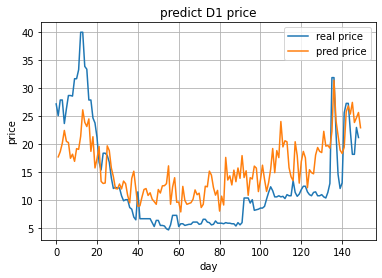

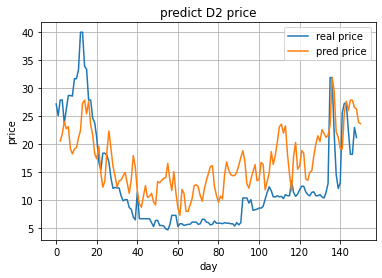

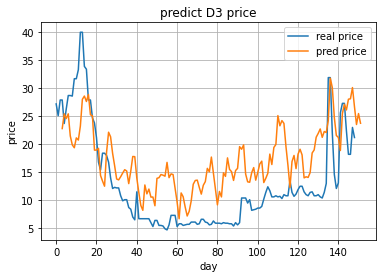

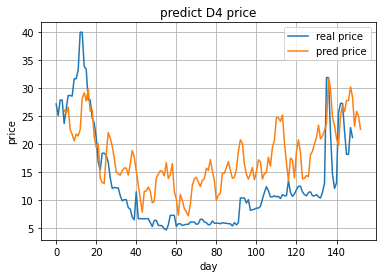

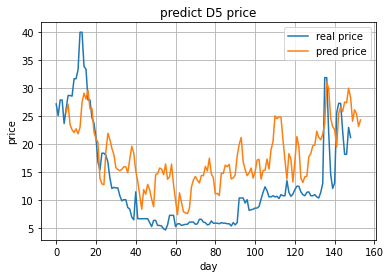

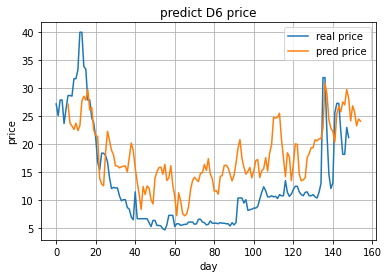

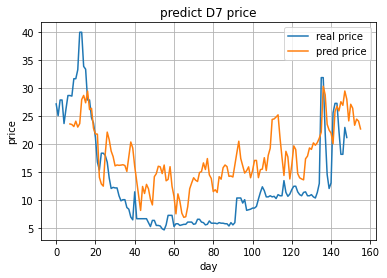

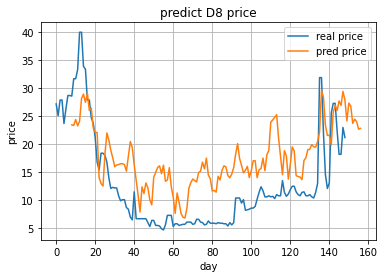

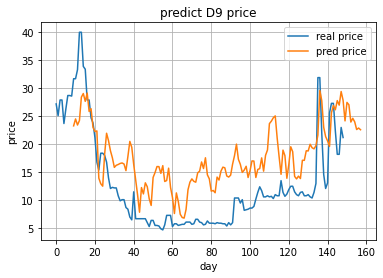

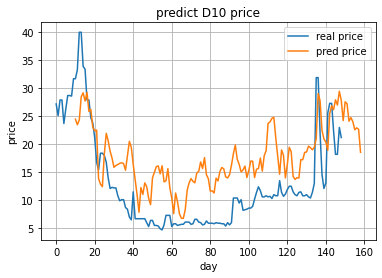

In [84]:
# 畫圖
real_price = y_real_price

for i in range(plotDay):
  pred_price = x_test_pred_price[:,i:i+1]
  for j in range(i+1):
    pred_price = np.insert(pred_price, 0, None)
  fig, ax = plt.subplots()
  ax.plot(real_price, label='real price')
  ax.plot(pred_price, label='pred price')

  ax.set(xlabel='day', ylabel='price', title='predict D'+str(i+1)+' price')
  ax.legend()
  ax.grid()

  plt.show()

In [85]:
## code會在這兒停止
# class StopExecution(Exception):
#   def _render_traceback_(self):
#     pass

# raise StopExecution

In [86]:
###############################以下是參考###############################################

In [87]:
# https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
# The input to every LSTM layer must be three-dimensional.

# The three dimensions of this input are:

# Samples. One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.